In [ ]:
import os

os.chdir("../../")

In [ ]:
import multiprocessing
import os
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from tqdm import tqdm
from src.plot import clear_axes, set_size

# Requires LaTeX, comment out if not available
mplstyle = ".matplotlib/bcov3d.mplstyle"
if os.path.exists(mplstyle) and shutil.which("latex") is not None:
    plt.style.use(mplstyle)
else:
    warnings.warn(
        f"Could not find {mplstyle} or LaTeX not installed. Using default matplotlib style.",
        UserWarning,
    )

root = "data"
imgdir = "img"
domdir = f"{root}/domains"
metadir = f"{root}/metadata"
fadir_aa = f"{root}/aa/fa"
treedir_aa = f"{root}/aa/trees"
fadir_3di = f"{root}/3di/fa"
treedir_3di = f"{root}/3di/trees"
palette = sns.color_palette("bright").as_hex()
outgroup = "'MCoV A59/Other/3jcl'"

## Metadata

In [3]:
meta_df = pd.read_csv(f"{metadir}/clean.csv")

print(meta_df.shape)

meta_df.head()

(676, 10)


,PDB,Virus,Variant,Domain,Antibody,Receptor/Other,Resolution,Release Date,Reference,MajorVariant
0,3jcl,MCoV A59,NaN,full,NaN,NaN,4.00,2016-02-03,NaN,Other
1,5i08,HCoV-OC43,NaN,full,NaN,NaN,4.04,2016-03-02,NaN,Other
2,5w9h,MERS-CoV,NaN,full,G4,NaN,4.00,2017-08-16,28807998.0,Other
3,5w9i,MERS-CoV,NaN,full,G4,NaN,3.60,2017-08-16,28807998.0,Other
4,5w9j,MERS-CoV,NaN,full,G4,NaN,4.80,2017-08-16,28807998.0,Other


In [4]:
def get_resolution(pdb_id: str):
    pdb_id = pdb_id.lower()
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    # Resolution is under "rcsb_entry_info"
    return (pdb_id, data["rcsb_entry_info"].get("resolution_combined")[0])


# Get the resolutions of all PDB IDs in metadata using multiprocessing
threads = 8
with multiprocessing.Pool(processes=threads) as pool:
    ids = list(meta_df.PDB)

    work = pool.imap_unordered(get_resolution, ids)

    outputs = dict(tqdm(work, total=len(ids), desc="Extracting resolutions..."))

Extracting resolutions...:   0%|          | 0/676 [00:00<?, ?it/s]

Extracting resolutions...: 100%|██████████| 676/676 [00:22<00:00, 30.62it/s]


In [5]:
receptors = pd.read_csv(f"{metadir}/receptors.csv")

virus2subgenus = receptors[["Virus", "Subgenus"]]

virus2subgenus.Virus = virus2subgenus.Virus.apply(lambda x: x.split("(")[0].strip())

virus2subgenus = (
    virus2subgenus.drop_duplicates().set_index("Virus")["Subgenus"].to_dict()
)

virus2receptor = receptors[["Virus", "Receptor"]]

virus2receptor.Virus = virus2receptor.Virus.apply(lambda x: x.split("(")[0].strip())

virus2receptor = (
    virus2receptor.drop_duplicates().set_index("Virus")["Receptor"].to_dict()
)

/tmp/ipykernel_3412883/2279675982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virus2subgenus.Virus = virus2subgenus.Virus.apply(lambda x: x.split("(")[0].strip())
/tmp/ipykernel_3412883/2279675982.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virus2receptor.Virus = virus2receptor.Virus.apply(lambda x: x.split("(")[0].strip())


In [6]:
subset1 = pd.read_csv(f"{metadir}/subset1.csv")

meta_df["is_subset1"] = meta_df.PDB.apply(
    lambda x: "Subset@1" if x in subset1.PDB.values else "full"
)
meta_df["resolution"] = meta_df.PDB.str.lower().map(outputs)
meta_df["subgenus"] = meta_df.Virus.map(virus2subgenus)
meta_df["receptor"] = meta_df.Virus.map(virus2receptor)

meta_df.head()

,PDB,Virus,Variant,Domain,Antibody,Receptor/Other,Resolution,Release Date,Reference,MajorVariant,is_subset1,resolution,subgenus,receptor
0,3jcl,MCoV A59,NaN,full,NaN,NaN,4.00,2016-02-03,NaN,Other,Subset@1,4.00,Emb.,CEACAM1
1,5i08,HCoV-OC43,NaN,full,NaN,NaN,4.04,2016-03-02,NaN,Other,full,4.04,Emb.,9-O-Ac-Sia
2,5w9h,MERS-CoV,NaN,full,G4,NaN,4.00,2017-08-16,28807998.0,Other,full,4.00,Merb.,DPP4
3,5w9i,MERS-CoV,NaN,full,G4,NaN,3.60,2017-08-16,28807998.0,Other,full,3.60,Merb.,DPP4
4,5w9j,MERS-CoV,NaN,full,G4,NaN,4.80,2017-08-16,28807998.0,Other,full,4.80,Merb.,DPP4


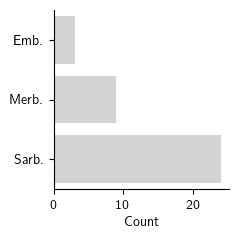

In [ ]:
fig1, ax1 = plt.subplots(1, 1, figsize=set_size(180, "s"))
sns.countplot(
    data=meta_df.query("is_subset1 == 'Subset@1'"), y="subgenus", color="lightgrey"
)
ax1.set_xlabel("Count")
ax1.set_ylabel("")
plt.savefig(f"{imgdir}/subgenus_counts.pdf", format="pdf", bbox_inches="tight")
plt.show()

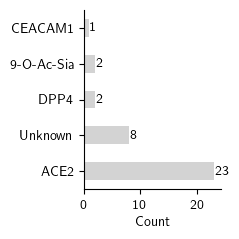

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize=set_size(180, "s"))
meta_df.query("is_subset1 == 'Subset@1'").receptor.value_counts().plot(
    kind="barh", color="lightgrey"
)
for i, v in enumerate(meta_df.query("is_subset1 == 'Subset@1'").receptor.value_counts()):
    ax2.text(v + 0.2, i, f"{int(v)}", va="center", weight="bold", color="black")
ax2.set_xlabel("Count")
ax2.set_ylabel("")
plt.savefig(f"{imgdir}/receptor_counts.pdf", format="pdf", bbox_inches="tight")
plt.show()

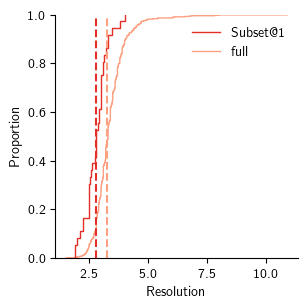

In [ ]:
fig3, ax3 = plt.subplots(1, 1, figsize=set_size(230, "s"))

palette3 = sns.color_palette("Reds_r", n_colors=2)
g = sns.ecdfplot(data=meta_df, x="resolution", hue="is_subset1", palette=palette3)
axvline_kwargs = dict(ls="--", label="median", lw=1.5)
ax3.axvline(meta_df.resolution.median(), color=palette3[1], **axvline_kwargs)
ax3.axvline(
    meta_df.query("is_subset1 == 'Subset@1'").resolution.median(),
    color=palette3[0],
    **axvline_kwargs
)
g.legend_.set_title(None)
ax3.set_xlabel("Resolution")
plt.savefig(f"{imgdir}/resolution_ecdf.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Sequence stats

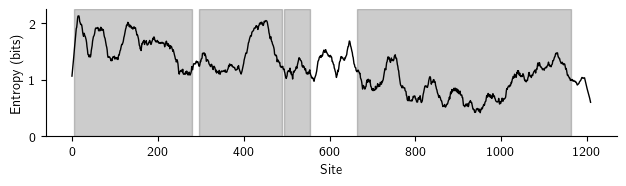

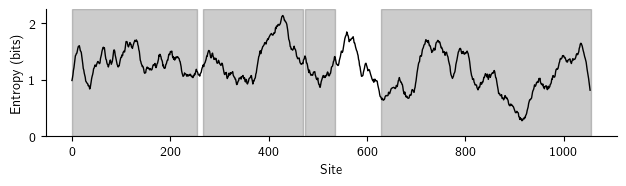

In [ ]:
from src.fasta import site_entropy

seq_aa = f"{fadir_aa}/subset1.fa"
seq_3di = f"{fadir_3di}/subset1.fa"

window = 30
ent_aa = site_entropy(seq_aa, window)
ent_3di = site_entropy(seq_3di, window)

w, h = set_size(230, "h")
fig2a, ax2a = plt.subplots(1, 1, figsize=(2 * w, h))
ax2a.plot(ent_aa, color="k")

ax2a.axvspan(5, 280, color="k", alpha=0.2)
ax2a.axvspan(296, 489, color="k", alpha=0.2)
ax2a.axvspan(495, 554, color="k", alpha=0.2)
ax2a.axvspan(663, 1163, color="k", alpha=0.2)
ax2a.set_xlabel("Site")
ax2a.set_ylabel("Entropy (bits)")
clear_axes()
ax2a.set_ylim(0, 2.25)
plt.savefig(f"{imgdir}/cons_aa.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

fig2b, ax2b = plt.subplots(1, 1, figsize=(2 * w, h))
ax2b.plot(ent_3di, color="k")
ax2b.axvspan(1, 255, color="k", alpha=0.2)
ax2b.axvspan(267, 470, color="k", alpha=0.2)
ax2b.axvspan(474, 535, color="k", alpha=0.2)
ax2b.axvspan(629, 1055, color="k", alpha=0.2)
clear_axes()
ax2b.set_xlabel("Site")
ax2b.set_ylabel("Entropy (bits)")
ax2b.set_ylim(0, 2.25)
plt.savefig(f"{imgdir}/cons_3di.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

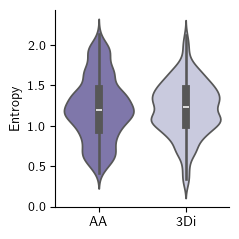

In [ ]:
conss = pd.concat(
    [
        pd.Series(ent_aa).rename("AA"),
        pd.Series(ent_3di).rename("3Di"),
    ],
    axis=1,
)

plt.figure(figsize=set_size(180, "s"))
sns.violinplot(
    data=conss.melt(), x="variable", y="value", palette="Purples_r", hue="variable"
)
plt.ylabel("Entropy")
plt.xlabel("")
clear_axes()
plt.savefig(f"{imgdir}/cons_violin.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

[np.float64(-0.029), np.float64(0.032)]
0.0009603689132391207


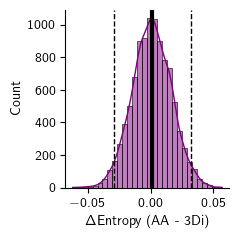

In [ ]:
def bootstrap_CI(x, y, nbr_draws=10000, ci=95, seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.array(x)
    y = np.array(y)
    means = np.zeros(nbr_draws)

    for n in range(nbr_draws):
        x_sample = np.random.choice(x, size=len(x), replace=True)
        y_sample = np.random.choice(y, size=len(y), replace=True)
        means[n] = x_sample.mean() - y_sample.mean()

    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return means, [round(lower, 3), round(upper, 3)]


plt.figure(figsize=set_size(180, "s"))
means, ci = bootstrap_CI(conss.AA.dropna(), conss["3Di"].dropna(), seed=42)
print(ci)
print(means.mean())
sns.histplot(means, kde=True, color="purple", alpha=0.5, bins=30)
plt.axvline(ci[0], color="k", linestyle="--")
plt.axvline(ci[1], color="k", linestyle="--")
plt.axvline(means.mean(), color="k", linestyle="-", linewidth=3)
plt.xlabel(r"$\Delta$Entropy (AA - 3Di)")
plt.ylabel("Count")
clear_axes()
plt.savefig(f"{imgdir}/cons_bootstrap.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

In [5]:
doms = pd.read_csv(f"{domdir}/subset1_with_3di.tsv", sep="\t")

dom_gb = doms.groupby(["entry_accession", "entry_description"]).agg(
    {"start_subset": "median", "end_subset": "median"}
)

dom_gb["length"] = dom_gb.end_subset - dom_gb.start_subset + 1

dom_gb.sort_values("length", ascending=False, inplace=True)

dom_gb.sort_values(by="start_subset").query("length < 1000")

,,start_subset,end_subset,length
entry_accession,entry_description,,,
IPR032500,"Spike glycoprotein S1, N-terminal domain, betacoronavirus-like",5.0,276.0,272.0
IPR044341,"Spike (S) protein S1 subunit, N-terminal domain, SARS-CoV-like",11.0,277.0,267.0
IPR043002,"Spike glycoprotein, N-terminal domain superfamily",15.0,280.0,266.0
IPR044364,"Spike (S) protein S1 subunit, receptor-binding domain, HKU5-like",293.0,482.0,190.0
-,-,300.0,434.0,135.0
IPR036326,"Spike S1 subunit, receptor binding domain superfamily, betacoronavirus",306.0,469.5,164.5
IPR018548,"Spike (S) protein S1 subunit, receptor-binding domain, betacoronavirus",307.0,489.0,183.0
IPR043607,"Coronavirus spike glycoprotein S1, C-terminal",497.0,552.0,56.0
IPR002552,"Spike glycoprotein S2, coronavirus",663.5,1163.0,500.5


In [6]:
domains_aa = {
    "S1 (NTD)": [5, 280],
    "S1 (RBD)": [296, 489],
    "S1 (RBM)": [398, 442],
    "S1 (CT)": [495, 554],
    "S2": [663, 1163],
    "S2 (HR1)": [863, 980],
    "S2 (HR2)": [1097, 1180],
    "CT": [1140, 1189],
}

domains_3di = {
    "S1 (NTD)": [1, 255],
    "S1 (RBD)": [267, 470],
    # "S1 (RBM)": [374, 432],
    "S1 (CT)": [474, 535],
    "S2": [629, 1055],
    "S2 (HR1)": [803, 908],
    "S2 (HR2)": [1048, 1055],
}

In [7]:
dom_gb = (
    doms.groupby(["entry_accession", "entry_description"])
    .agg({"start_subset_3di": "median", "end_subset_3di": "median"})
    .round()
)

dom_gb["length"] = dom_gb.end_subset_3di - dom_gb.start_subset_3di + 1

dom_gb.sort_values("length", ascending=False, inplace=True)

dom_gb.query("length < 1000").sort_values(by="start_subset_3di")

,,start_subset_3di,end_subset_3di,length
entry_accession,entry_description,,,
IPR032500,"Spike glycoprotein S1, N-terminal domain, betacoronavirus-like",1.0,251.0,251.0
IPR044341,"Spike (S) protein S1 subunit, N-terminal domain, SARS-CoV-like",1.0,252.0,252.0
IPR043002,"Spike glycoprotein, N-terminal domain superfamily",2.0,255.0,254.0
IPR044364,"Spike (S) protein S1 subunit, receptor-binding domain, HKU5-like",267.0,464.0,198.0
-,-,274.0,410.0,137.0
IPR036326,"Spike S1 subunit, receptor binding domain superfamily, betacoronavirus",280.0,438.0,159.0
IPR018548,"Spike (S) protein S1 subunit, receptor-binding domain, betacoronavirus",281.0,470.0,190.0
IPR043607,"Coronavirus spike glycoprotein S1, C-terminal",477.0,534.0,58.0
IPR002552,"Spike glycoprotein S2, coronavirus",629.0,1055.0,427.0


## MAST analysis

In [10]:
from src.iqtreestats import get_tree_stats
from src.plot import plot_tree_stats, plot_mastscores


def mast_analysis(
    mast_path,
    max_values,
    criterion="BIC",
    outgroup=None,
    order=None,
    tree_figsize=(9, 14),
    **siteprob_kwargs,
):
    mast_scores = (
        pd.read_csv(f"{mast_path}.csv", index_col=0)
        .rename_axis(index="n_classes")
        .sort_index()
    )

    argbest = mast_scores[criterion].idxmin()
    best_score = mast_scores[criterion][argbest]

    print(f"# classes wrt {criterion}: {argbest} ({best_score:.2f})")

    mast_scores.rename(index={"all": int(mast_scores.index[-2]) + 1}, inplace=True)

    mast_scores.index = mast_scores.index.astype(int)

    fig, ax = plot_mastscores(mast_scores)
    plt.savefig(f"{mast_path}_mast_scores.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.show()

    fig, ax = plot_mastscores(mast_scores.loc[:, ["BIC"]])
    plt.savefig(
        f"{mast_path}_mast_scores_only_BIC.pdf", bbox_inches="tight", pad_inches=0.1
    )
    plt.show()

    fig, ax = plot_tree_stats(
        f"{mast_path}/{argbest}.treefile.annotated",
        max_values=max_values,
        outgroup=outgroup,
        order=order,
    )
    plt.savefig(f"{mast_path}_tree_stats.pdf", bbox_inches="tight", pad_inches=0.1)
    plt.show()

# classes wrt BIC: 3 (54884.61)


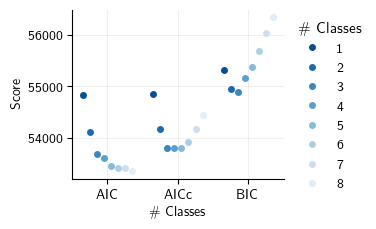

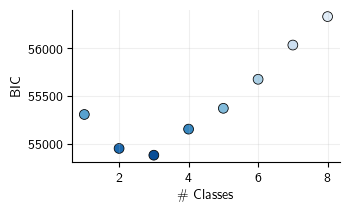

R callback write-console: Loading required package: maps
  


[1] "'MCoV A59/Other/3jcl'"
[1] "'MCoV A59/Other/3jcl'"
[1] "'MCoV A59/Other/3jcl'"
  index       MCL  stemminess  tree_length  weight
0     1  0.152838    0.648390    19.438123  0.1691
1     2  0.087094    0.725127     5.071728  0.6109
2     3  0.110283    0.667692     9.017150  0.2201
  index       MCL  stemminess  tree_length  weight
0     1  0.152838    0.648390    19.438123  0.1691
2     3  0.110283    0.667692     9.017150  0.2201
1     2  0.087094    0.725127     5.071728  0.6109


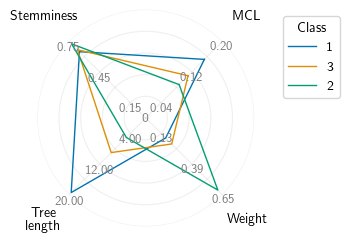

In [11]:
cut_single_aa = f"{treedir_aa}/mast/subset1"

siteprob_kwargs = {
    "window": 20,
    "minp": 0,
    "domains": domains_aa,
    "showprob": True,
    "normalize": True,
}

max_values = {"MCL": 0.20, "stemminess": 0.75, "tree_length": 20.0, "weight": 0.65}

mast_analysis(
    cut_single_aa,
    criterion="BIC",
    tree_figsize=(10, 8),
    max_values=max_values,
    outgroup=outgroup,
    order=[0, 2, 1],
    **siteprob_kwargs,
)

# classes wrt BIC: 3 (75997.23)


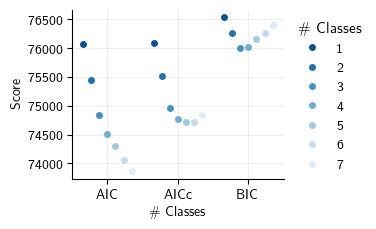

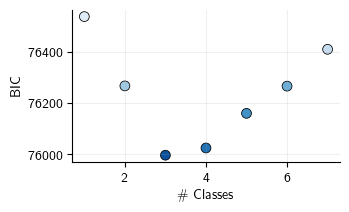

  index       MCL  stemminess  tree_length  weight
0     1  0.322372    0.269391     8.968472  0.3549
1     2  0.306863    0.211758     7.957318  0.2525
2     3  0.320282    0.242044    13.407898  0.3926
  index       MCL  stemminess  tree_length  weight
1     2  0.306863    0.211758     7.957318  0.2525
0     1  0.322372    0.269391     8.968472  0.3549
2     3  0.320282    0.242044    13.407898  0.3926


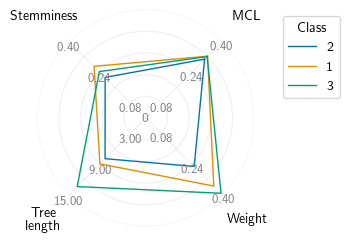

In [12]:
cut_single_3di = f"{treedir_3di}/mast/subset1"

siteprob_kwargs = {
    "window": 20,
    "minp": 0,
    "domains": domains_3di,
    "showprob": True,
    "normalize": True,
}

max_values = {"MCL": 0.4, "stemminess": 0.4, "tree_length": 15, "weight": 0.4}

mast_analysis(
    cut_single_3di,
    criterion="BIC",
    tree_figsize=(10, 8),
    max_values=max_values,
    outgroup=outgroup,
    order=[1, 0, 2],
    **siteprob_kwargs,
)

In [15]:
import importlib
import src.iqtreestats
import src.plot
importlib.reload(src.iqtreestats)
importlib.reload(src.plot)

from src.iqtreestats import prepare_sitelh
from src.plot import plot_sites

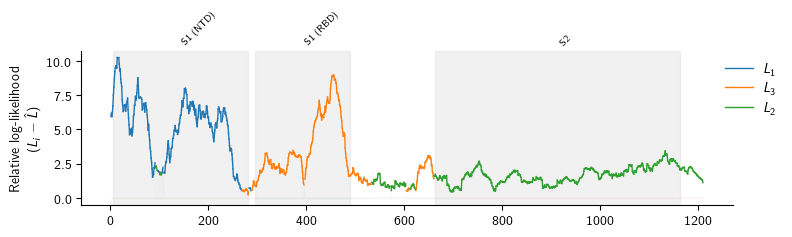

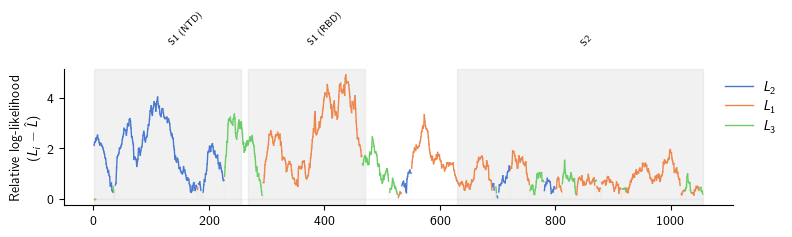

In [16]:
argbest = 3

sitelh_file_aa = f"{treedir_aa}/mast/subset1/{argbest}.sitelh"
sitelh_file_3di = f"{treedir_3di}/mast/subset1/{argbest}.sitelh"

window = 30
palette_aa = sns.color_palette("tab10").as_hex()
palette_3di = sns.color_palette("muted").as_hex()

kwargs = {"label": "Relative log-likelihood\n" + r"($L_i - \hat{L}$)"}

plot_sites(
    slh=prepare_sitelh(sitelh_file_aa, window),
    domains=domains_aa,
    palette=palette_aa,
    figname="sitelh_aa",
    order=[r"$L_1$", r"$L_3$", r"$L_2$"],
    offset=11,
    **kwargs
)

plot_sites(
    slh=prepare_sitelh(sitelh_file_3di, window),
    domains=domains_3di,
    palette=palette_3di,
    figname="sitelh_3di",
    order=[r"$L_2$", r"$L_1$", r"$L_3$"],
    offset=6,
    **kwargs
)